# 03 - Modélisation et prédiction (bureau de vote)

Objectif : tester des algorithmes robustes (baseline + gradient boosting) sur les données prétraitées, évaluer via validation temporelle, puis projeter les municipales 2026 bureau par bureau avant intégration Gradio.

## Plan
- Charger les données bloc-level (`data/processed/elections_blocs.parquet` ou CSV)
- Construire les features (lags, participation, croissance population, type de scrutin)
- Définir deux familles de modèles :
  - Baseline régression régularisée (référence interprétable)
  - Gradient Boosting (HistGradientBoosting par défaut ; LightGBM/XGBoost/CatBoost si installés)
- Validation temporelle (split par année) : MAE, RMSE, gagnant du bureau
- Entrainement final + projection municipales 2026 (tour 1)
- Sauvegarde des prédictions pour Gradio

In [1]:
from pathlib import Path
import sys
import warnings
import numpy as np
import pandas as pd
from datetime import datetime

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMRegressor was fitted with feature names",
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import HistGradientBoostingRegressor

try:
    from lightgbm import LGBMRegressor
except Exception:
    LGBMRegressor = None

try:
    import xgboost as xgb
except Exception:
    xgb = None

try:
    import catboost
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.append(str(PROJECT_ROOT))

from src.pipeline import normalize_bloc
from src.constants import CANDIDATE_CATEGORIES


In [2]:
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
processed_path = PROCESSED_DIR / "elections_blocs.parquet"
csv_fallback = PROCESSED_DIR / "elections_blocs.csv"
COMMUNE_PREFIX = "34301"

def build_elections_blocs_fallback() -> pd.DataFrame:
    from src.features.build_features import load_elections_long as load_elections_long_clean
    from src.pipeline import (
        load_bloc_mapping,
        expand_voix_by_bloc,
        attach_national_results,
        compute_population_growth,
        add_lag_features,
    )

    elections_long_path = INTERIM_DIR / "elections_long.parquet"
    mapping_path = PROJECT_ROOT / "data" / "mapping_candidats_blocs.csv"
    if not elections_long_path.exists():
        raise FileNotFoundError("Aucun fichier elections_long.parquet trouve dans data/interim.")
    if not mapping_path.exists():
        raise FileNotFoundError("Aucun fichier mapping_candidats_blocs.csv trouve dans data/.")

    elections_long = load_elections_long_clean(elections_long_path)
    if COMMUNE_PREFIX:
        elections_long = elections_long[
            elections_long["code_bv"].astype(str).str.startswith(COMMUNE_PREFIX)
        ]
    blocs = expand_voix_by_bloc(elections_long, load_bloc_mapping(mapping_path))
    blocs = attach_national_results(blocs)
    blocs = compute_population_growth(blocs, base_year=2014)
    blocs = add_lag_features(blocs)
    return blocs

if processed_path.exists():
    elections_blocs = pd.read_parquet(processed_path)
elif csv_fallback.exists():
    elections_blocs = pd.read_csv(csv_fallback, sep=";")
else:
    elections_blocs = pd.DataFrame()

if elections_blocs.empty:
    print("elections_blocs vide -> reconstruction depuis elections_long.parquet")
    elections_blocs = build_elections_blocs_fallback()

# Normalisations de base
for col in ["date_scrutin"]:
    if col in elections_blocs.columns:
        elections_blocs[col] = pd.to_datetime(elections_blocs[col])
for col in ["voix_bloc", "exprimes", "inscrits", "votants", "part_bloc", "part_bloc_lag1", "taux_participation_bv_lag1", "croissance_inscrits_depuis_base"]:
    if col in elections_blocs.columns:
        elections_blocs[col] = pd.to_numeric(elections_blocs[col], errors="coerce")

elections_blocs["bloc"] = elections_blocs["bloc"].apply(normalize_bloc)

print(elections_blocs.shape)
elections_blocs.head()


(1650, 24)


,code_bv,nom_bv,date_scrutin,annee,type_scrutin,tour,bloc,voix_bloc,exprimes,inscrits,...,taux_participation_bv,ecart_bloc_vs_national,ecart_participation_vs_nat,code_commune,nom_commune,croissance_inscrits_depuis_base,part_bloc_lag1,ecart_bloc_vs_national_lag1,taux_participation_bv_lag1,annee_centre
0,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,NaN,NaN,NaN,0.0
1,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,0.0,0.0,0.672557,0.0
2,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,0.0,0.0,0.672557,0.0
3,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,0.0,0.0,0.672557,0.0
4,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,0.0,0.0,0.672557,0.0


## Fonctions utilitaires : features, splits et métriques
- Construction d'une table modèle (une ligne = bureau x bloc x scrutin)
- Validation temporelle : split par années croissantes pour éviter la fuite d'info
- Calcul des métriques : MAE, RMSE, exactitude du gagnant du bureau (classement par bloc)

In [3]:
TARGET_ELECTION = "municipales"
TARGET_YEAR = 2026
PREDICTION_DATE = pd.Timestamp(f"{TARGET_YEAR}-03-15")

# Colonnes numériques candidates pour la régression
NUM_FEATURES = [
    "annee",
    "tour",
    "annee_centre",
    "part_bloc_lag1",
    "taux_participation_bv",
    "taux_participation_bv_lag1",
    "ecart_bloc_vs_national",
    "ecart_bloc_vs_national_lag1",
    "croissance_inscrits_depuis_base",
]
CAT_FEATURES = ["bloc", "type_scrutin"]

def build_model_table(df: pd.DataFrame, drop_na_target: bool = True) -> pd.DataFrame:
    base = df.copy()
    base["bloc"] = base["bloc"].apply(normalize_bloc)
    base["type_scrutin"] = base["type_scrutin"].fillna("inconnu").astype(str).str.lower()
    base["tour"] = pd.to_numeric(base["tour"], errors="coerce").fillna(1).astype(int)
    # Ne conserver que les 1ers tours (sauf européennes qui n'ont qu'un tour)
    if "tour" in base.columns and "type_scrutin" in base.columns:
        base = base[(base["tour"] == 1) | (base["type_scrutin"] == "europeennes")].copy()
    # Cible : part_bloc, calculée si manquante
    if "part_bloc" not in base or base["part_bloc"].isna().all():
        base["part_bloc"] = base["voix_bloc"] / base["exprimes"]
    base["part_bloc"] = pd.to_numeric(base["part_bloc"], errors="coerce")
    if drop_na_target:
        base = base.dropna(subset=["part_bloc"])
    return base

def time_series_folds(df: pd.DataFrame, n_splits: int = 4):
    # Split sur la base de l'année, en conservant l'ordre chronologique
    df_sorted = df.sort_values("annee").reset_index(drop=True)
    n_samples = len(df_sorted)
    if n_samples < 2:
        return []
    max_splits = min(n_splits, n_samples - 1)
    if max_splits < n_splits:
        print(f"n_splits reduit a {max_splits} (n_samples={n_samples}).")
    tscv = TimeSeriesSplit(n_splits=max_splits)
    for train_idx, test_idx in tscv.split(df_sorted):
        yield train_idx, test_idx


def time_series_event_folds(df: pd.DataFrame, n_splits: int = 4):
    """
    Split par scrutin (type/date/tour) pour eviter toute fuite.
    Chaque fold teste des scrutins entiers, dans l'ordre chronologique.
    """
    required = {"date_scrutin", "type_scrutin", "tour"}
    if not required.issubset(df.columns):
        raise ValueError(f"Colonnes manquantes pour le split strict: {required - set(df.columns)}")
    dates = pd.to_datetime(df["date_scrutin"], errors="coerce")
    event_key = (
        df["type_scrutin"].astype(str).str.lower().str.strip()
        + "|" + df["tour"].astype(str)
        + "|" + dates.dt.strftime("%Y-%m-%d").fillna("")
    )
    events = (
        pd.DataFrame({
            "type_scrutin": df["type_scrutin"].astype(str).str.lower().str.strip(),
            "tour": df["tour"].astype(str),
            "date_scrutin": dates,
            "event_key": event_key,
        })
        .dropna(subset=["date_scrutin"])
        .drop_duplicates(subset=["event_key"])
        .sort_values(["date_scrutin", "type_scrutin", "tour"])
        .reset_index(drop=True)
    )
    if events.empty:
        return []
    n_events = len(events)
    max_splits = min(n_splits, n_events - 1)
    if max_splits < 1:
        return []
    if max_splits < n_splits:
        print(f"n_splits reduit a {max_splits} (n_events={n_events}).")
    tscv = TimeSeriesSplit(n_splits=max_splits)
    for train_evt_idx, test_evt_idx in tscv.split(events):
        train_keys = set(events.iloc[train_evt_idx]["event_key"])
        test_keys = set(events.iloc[test_evt_idx]["event_key"])
        train_idx = df.index[event_key.isin(train_keys)].to_numpy()
        test_idx = df.index[event_key.isin(test_keys)].to_numpy()
        yield train_idx, test_idx

def winner_accuracy(
    y_true: pd.Series, y_pred: pd.Series, blocs: pd.Series, bv_codes: pd.Series
) -> float:
    df = pd.DataFrame(
        {
            "code_bv": bv_codes,
            "true": y_true,
            "pred": y_pred,
            "bloc": blocs,
        }
    ).dropna(subset=["code_bv"])
    if df.empty:
        return np.nan
    winners_true = (
        df.loc[df.groupby("code_bv")["true"].idxmax(), ["code_bv", "bloc"]]
        .set_index("code_bv")
        ["bloc"]
    )
    winners_pred = (
        df.loc[df.groupby("code_bv")["pred"].idxmax(), ["code_bv", "bloc"]]
        .set_index("code_bv")
        ["bloc"]
    )
    common_idx = winners_true.index.intersection(winners_pred.index)
    if len(common_idx) == 0:
        return np.nan
    return (winners_true.loc[common_idx] == winners_pred.loc[common_idx]).mean()


## Préparation du jeu d'entraînement
- Sélection des colonnes utiles
- Imputation des valeurs manquantes (médiane pour numériques)
- Encodage one-hot pour les variables catégorielles

In [4]:
model_df = build_model_table(elections_blocs, drop_na_target=True)
# Assurer un ordre chronologique cohérent avec les folds
model_df = model_df.sort_values("annee").reset_index(drop=True)

feature_cols = NUM_FEATURES + CAT_FEATURES
# Supprimer les features entièrement vides (ex: ecarts nationaux si non disponibles)
all_na_cols = [c for c in feature_cols if c in model_df.columns and model_df[c].isna().all()]
if all_na_cols:
    print(f"Features supprimées car entièrement NA: {all_na_cols}")
    feature_cols = [c for c in feature_cols if c not in all_na_cols]

X = model_df[feature_cols].reset_index(drop=True)
y = model_df["part_bloc"].reset_index(drop=True)
# Folds temporels alignés sur le DataFrame réindexé
folds = list(time_series_event_folds(model_df.reset_index(drop=True), n_splits=4))


In [5]:
# Pondération des observations (optionnel)
def build_sample_weights(df: pd.DataFrame, mode: str = 'bloc_value', alpha: float = 2.0) -> pd.Series:
    weights = pd.Series(1.0, index=df.index, dtype='float')
    if mode in ('bloc', 'bloc_value'):
        bloc_counts = df['bloc'].value_counts()
        if not bloc_counts.empty:
            inv = bloc_counts.max() / bloc_counts
            weights *= df['bloc'].map(inv).fillna(1.0)
    if mode in ('value', 'bloc_value'):
        y = df['part_bloc'].clip(lower=0)
        weights *= 1 + alpha * y
    return weights

sample_weights = build_sample_weights(model_df, mode='bloc_value', alpha=2.0)


## Définition des modèles à tester
- **Ridge** sur la cible directe (baseline interprétable)
- **HistGradientBoostingRegressor** (robuste sur tabulaire)
- **LightGBM/XGBoost/CatBoost** si disponibles (recommandés en production)

In [6]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_features = NUM_FEATURES
categorical_features = CAT_FEATURES

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            categorical_features,
        ),
    ]
)

In [7]:
models = []

ridge_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", Ridge(alpha=1.0)),
    ]
)
models.append(("ridge", ridge_model))

ridge_reg = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", Ridge(alpha=10.0)),
    ]
)
models.append(("ridge_reg", ridge_reg))

# HistGradientBoosting (natif sklearn)
gbr_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        (
            "model",
            HistGradientBoostingRegressor(
                max_depth=6,
                learning_rate=0.05,
                max_iter=500,
                min_samples_leaf=20,
                l2_regularization=0.1,
            ),
        ),
    ]
)
models.append(("hist_gbr", gbr_model))

gbr_reg = Pipeline(
    steps=[
        ("prep", preprocessor),
        (
            "model",
            HistGradientBoostingRegressor(
                max_depth=4,
                learning_rate=0.05,
                max_iter=400,
                min_samples_leaf=50,
                l2_regularization=1.0,
            ),
        ),
    ]
)
models.append(("hist_gbr_reg", gbr_reg))

# LightGBM si dispo (souvent le meilleur sur ce type de données)
if LGBMRegressor is not None:
    lgbm = Pipeline(
        steps=[
            ("prep", preprocessor),
            (
                "model",
                LGBMRegressor(
                    objective="regression",
                    n_estimators=800,
                    learning_rate=0.05,
                    max_depth=-1,
                    num_leaves=31,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    force_row_wise=True,
                    verbosity=-1,
                    random_state=42,
                ),
            ),
        ]
    )
    models.append(("lightgbm", lgbm))

    lgbm_reg = Pipeline(
        steps=[
            ("prep", preprocessor),
            (
                "model",
                LGBMRegressor(
                    objective="regression",
                    n_estimators=600,
                    learning_rate=0.05,
                    max_depth=6,
                    num_leaves=16,
                    min_child_samples=20,
                    reg_alpha=0.0,
                    reg_lambda=0.5,
                    subsample=0.7,
                    colsample_bytree=0.7,
                    force_row_wise=True,
                    verbosity=-1,
                    random_state=42,
                ),
            ),
        ]
    )
    models.append(("lightgbm_reg", lgbm_reg))

# XGBoost si dispo
if xgb is not None:
    xgb_model = Pipeline(
        steps=[
            ("prep", preprocessor),
            (
                "model",
                xgb.XGBRegressor(
                    objective="reg:squarederror",
                    n_estimators=800,
                    learning_rate=0.05,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                ),
            ),
        ]
    )
    models.append(("xgboost", xgb_model))

    xgb_reg = Pipeline(
        steps=[
            ("prep", preprocessor),
            (
                "model",
                xgb.XGBRegressor(
                    objective="reg:squarederror",
                    n_estimators=600,
                    learning_rate=0.05,
                    max_depth=4,
                    min_child_weight=5,
                    reg_alpha=0.1,
                    reg_lambda=1.0,
                    subsample=0.7,
                    colsample_bytree=0.7,
                ),
            ),
        ]
    )
    models.append(("xgboost_reg", xgb_reg))

# CatBoost si dispo (gère bien les catégorielles)


## Évaluation temporelle
Validation par TimeSeriesSplit (train sur années passées, test sur années futures). Mesures :
- MAE / RMSE sur part des voix
- Exactitude du gagnant du bureau (classement par bloc sur chaque scrutin)

In [8]:
import inspect

def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    evs = explained_variance_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    denom = float(np.sum(np.abs(y_true)))
    wape = float(np.sum(np.abs(y_true - y_pred)) / denom) if denom > 0 else np.nan
    smape = float(np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)))
    bias = float(np.mean(y_pred - y_true))
    return {
        "mae": float(mae),
        "rmse": float(rmse),
        "medae": float(medae),
        "r2": float(r2),
        "explained_var": float(evs),
        "wape": float(wape),
        "smape": float(smape),
        "bias": float(bias),
    }

def fit_with_optional_weights(model, X_train, y_train, sample_weight=None):
    if sample_weight is None:
        model.fit(X_train, y_train)
        return
    estimator = model.named_steps.get("model") if hasattr(model, "named_steps") else model
    supports_weight = False
    try:
        supports_weight = "sample_weight" in inspect.signature(estimator.fit).parameters
    except Exception:
        supports_weight = False
    if supports_weight:
        fit_params = {"model__sample_weight": sample_weight} if hasattr(model, "named_steps") else {"sample_weight": sample_weight}
        model.fit(X_train, y_train, **fit_params)
    else:
        model.fit(X_train, y_train)

def evaluate_model(name, model, X, y, folds, sample_weights=None, compute_winner_acc=True, df_for_winner=None):
    metric_store = {
        "mae": [],
        "rmse": [],
        "medae": [],
        "r2": [],
        "explained_var": [],
        "wape": [],
        "smape": [],
        "bias": [],
    }
    win_accs = []
    folds_used = 0
    if not folds:
        print("Aucun fold disponible pour l'evaluation.")
        return {"model": name, **{k: np.nan for k in metric_store}, "winner_acc": np.nan, "folds_used": 0}
    weights = None if sample_weights is None else np.asarray(sample_weights)
    for train_idx, test_idx in folds:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        w_train = None if weights is None else weights[train_idx]
        # CatBoost peut planter si la cible est constante sur le fold ; on ajoute un très léger bruit
        if y_train.nunique() <= 1:
            y_train = y_train + np.random.normal(0, 1e-6, size=len(y_train))
        try:
            fit_with_optional_weights(model, X_train, y_train, sample_weight=w_train)
            preds = model.predict(X_test)
        except Exception as exc:
            print(f"Skip fold for {name} (reason: {exc})")
            continue
        fold_metrics = regression_metrics(y_test, preds)
        for key, value in fold_metrics.items():
            metric_store[key].append(value)
        if compute_winner_acc:
            ref_df = df_for_winner if df_for_winner is not None else model_df
            win_accs.append(
                winner_accuracy(
                    y_test.values,
                    preds,
                    blocs=ref_df.iloc[test_idx]["bloc"],
                    bv_codes=ref_df.iloc[test_idx]["code_bv"],
                )
            )
        folds_used += 1
    summary = {
        "model": name,
        **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},
        "winner_acc": np.nan if (not compute_winner_acc) or all(np.isnan(win_accs)) or len(win_accs) == 0 else float(np.nanmean(win_accs)),
        "folds_used": folds_used,
    }
    return summary

results = []
for name, model in models:
    print(f"Evaluation {name}...")
    res = evaluate_model(name, model, X, y, folds)
    results.append(res)

results_df = pd.DataFrame(results).sort_values("mae")
results_df

# Comparaison pondérée
RUN_WEIGHTED = True
results_weighted_df = pd.DataFrame()
if RUN_WEIGHTED and "sample_weights" in globals():
    results_weighted = []
    for name, model in models:
        print(f"Evaluation pondérée {name}...")
        res = evaluate_model(name, model, X, y, folds, sample_weights=sample_weights)
        res["model"] = f"{name}__weighted"
        results_weighted.append(res)
    results_weighted_df = pd.DataFrame(results_weighted).sort_values("mae")
    results_weighted_df


Evaluation ridge...
Evaluation ridge_reg...
Evaluation hist_gbr...
Evaluation hist_gbr_reg...
Evaluation lightgbm...
Evaluation lightgbm_reg...
Evaluation xgboost...
Evaluation xgboost_reg...
Evaluation pondérée ridge...
Evaluation pondérée ridge_reg...
Evaluation pondérée hist_gbr...
Evaluation pondérée hist_gbr_reg...
Evaluation pondérée lightgbm...
Evaluation pondérée lightgbm_reg...
Evaluation pondérée xgboost...
Evaluation pondérée xgboost_reg...


## Baseline naïf (dernier scrutin connu)
Utilise directement `part_bloc_lag1` comme prédicteur pour estimer si les modèles apportent un gain tangible par rapport au simple report du scrutin précédent.


In [9]:
def evaluate_naive_last_observation(df: pd.DataFrame, folds):
    metric_store = {
        "mae": [],
        "rmse": [],
        "medae": [],
        "r2": [],
        "explained_var": [],
        "wape": [],
        "smape": [],
        "bias": [],
    }
    win_accs = []
    folds_used = 0
    if not folds:
        return {"model": "naive_last_election", **{k: np.nan for k in metric_store}, "winner_acc": np.nan, "folds_used": 0}
    for train_idx, test_idx in folds:
        test_df = df.iloc[test_idx]
        preds = test_df["part_bloc_lag1"]
        mask = preds.notna() & test_df["part_bloc"].notna()
        if not mask.any():
            continue
        y_true = test_df.loc[mask, "part_bloc"]
        y_pred = preds.loc[mask]
        fold_metrics = regression_metrics(y_true, y_pred)
        for key, value in fold_metrics.items():
            metric_store[key].append(value)
        win_accs.append(
            winner_accuracy(
                y_true.values,
                y_pred.values,
                blocs=test_df.loc[mask, "bloc"],
                bv_codes=test_df.loc[mask, "code_bv"],
            )
        )
        folds_used += 1
    return {
        "model": "naive_last_election",
        **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},
        "winner_acc": np.nan if all(np.isnan(win_accs)) or len(win_accs) == 0 else float(np.nanmean(win_accs)),
        "folds_used": folds_used,
    }

baseline_res = evaluate_naive_last_observation(model_df, folds)
results_df = pd.concat([pd.DataFrame([baseline_res]), results_df]).sort_values("mae").reset_index(drop=True)

USE_WEIGHTED_MODEL = False
if USE_WEIGHTED_MODEL and not results_weighted_df.empty:
    model_names = [name for name, _ in models]
    weighted_filtered = results_weighted_df[results_weighted_df["model"].str.contains("__weighted")].reset_index(drop=True)
    weighted_filtered["base_model"] = weighted_filtered["model"].str.replace("__weighted", "", regex=False)
    best_model_name = weighted_filtered.iloc[0]["base_model"]
    best_model = dict(models)[best_model_name]
else:
    model_names = [name for name, _ in models]
    model_results_df = results_df[results_df["model"].isin(model_names)].reset_index(drop=True)
    best_model_name = model_results_df.iloc[0]["model"]
    best_model = dict(models)[best_model_name]
results_df


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/888773043.py:38: RuntimeWarning: Mean of empty slice
  **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},


,model,mae,rmse,medae,r2,explained_var,wape,smape,bias,winner_acc,folds_used
0,naive_last_election,0.000000,0.000000,0.000000,1.000000,1.000000e+00,NaN,0.000000,0.000000,1.000000,4
1,ridge,0.011031,0.013579,0.012863,-0.437044,-3.539382e-06,1.000012,1.998531,-0.008343,0.750000,4
2,ridge_reg,0.016074,0.018636,0.017984,-0.437027,-3.352585e-07,0.999999,1.999117,-0.003213,0.750000,4
3,hist_gbr_reg,0.026691,0.029267,0.029070,-0.437034,-1.564966e-06,1.000003,1.993144,0.006774,0.774194,4
4,hist_gbr,0.028235,0.030719,0.029694,-0.437033,-1.840431e-06,1.000004,1.992638,0.008886,0.806452,4
5,xgboost_reg,0.030131,0.035232,0.032013,-0.437030,2.500000e-01,1.000000,1.980480,0.010844,0.750000,4
6,lightgbm_reg,0.035109,0.040711,0.036831,-0.437038,-1.526770e-06,1.000008,1.998704,0.015770,0.774194,4
7,xgboost,0.035416,0.041367,0.037292,-0.437031,0.000000e+00,1.000001,1.994588,0.016130,0.750000,4
8,lightgbm,0.036208,0.042100,0.037678,-0.437040,-5.538453e-07,1.000011,1.999008,0.016757,0.854839,4


In [10]:
from sklearn.base import clone

RUN_PER_BLOC = True
if not RUN_PER_BLOC:
    print("Evaluation par bloc desactivee.")
else:
    per_bloc_feature_cols = [c for c in feature_cols if c != "bloc"]
    per_bloc_num_features = [c for c in NUM_FEATURES if c in per_bloc_feature_cols]
    per_bloc_cat_features = [c for c in CAT_FEATURES if c != "bloc"]
    per_bloc_preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), per_bloc_num_features),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore")),
                    ]
                ),
                per_bloc_cat_features,
            ),
        ]
    )

    def make_per_bloc_model(base_model):
        if hasattr(base_model, "named_steps") and "model" in base_model.named_steps:
            estimator = base_model.named_steps["model"]
            return Pipeline([("prep", per_bloc_preprocessor), ("model", clone(estimator))])
        return clone(base_model)

    per_bloc_rows = []
    for bloc_name, bloc_df in model_df.groupby("bloc"):
        bloc_df = bloc_df.sort_values("annee").reset_index(drop=True)
        if len(bloc_df) < 30:
            continue
        bloc_folds = list(time_series_event_folds(bloc_df, n_splits=3))
        if not bloc_folds:
            continue
        X_bloc = bloc_df[per_bloc_feature_cols]
        y_bloc = bloc_df["part_bloc"]
        bloc_model = make_per_bloc_model(best_model)
        res = evaluate_model(
            f"{best_model_name}__{bloc_name}",
            bloc_model,
            X_bloc,
            y_bloc,
            bloc_folds,
            compute_winner_acc=False,
            df_for_winner=bloc_df,
        )
        res["bloc"] = bloc_name
        res["n_samples"] = len(bloc_df)
        res["n_events"] = bloc_df[["type_scrutin", "tour", "date_scrutin"]].drop_duplicates().shape[0]
        per_bloc_rows.append(res)

    per_bloc_results = pd.DataFrame(per_bloc_rows).sort_values("mae") if per_bloc_rows else pd.DataFrame()
    per_bloc_results


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2112122514.py:88: RuntimeWarning: Mean of empty slice
  **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},


## Validation leave-one-élection-out
Tenue d'une année complète en test (tout type de scrutin confondu) pour mesurer la généralisation temporelle du meilleur modèle hors baseline.


In [11]:
def leave_one_election_out_eval(model, df, feature_cols):
    rows = []
    for holdout_year in sorted(df["annee"].dropna().unique()):
        train_df = df[df["annee"] != holdout_year]
        test_df = df[df["annee"] == holdout_year]
        if train_df.empty or test_df.empty:
            continue
        try:
            model.fit(train_df[feature_cols], train_df["part_bloc"])
            preds = model.predict(test_df[feature_cols])
        except Exception as exc:
            print(f"Skip year {holdout_year} (reason: {exc})")
            continue
        rows.append(
            {
                "holdout_year": int(holdout_year),
                "mae": mean_absolute_error(test_df["part_bloc"], preds),
                "rmse": np.sqrt(mean_squared_error(test_df["part_bloc"], preds)),
                "winner_acc": winner_accuracy(
                    test_df["part_bloc"].values,
                    preds,
                    blocs=test_df["bloc"],
                    bv_codes=test_df["code_bv"],
                ),
            }
        )
    return pd.DataFrame(rows).sort_values("holdout_year")

loeo_results = leave_one_election_out_eval(best_model, model_df, feature_cols)
loeo_results


,holdout_year,mae,rmse,winner_acc
0,2014,0.006201,0.012461,1.0
1,2017,0.000409,0.000527,1.0
2,2019,0.000303,0.000398,1.0
3,2020,0.057860,0.059233,1.0
4,2021,0.001337,0.001385,1.0
5,2022,0.000695,0.000764,1.0
6,2024,0.000848,0.001041,1.0


## Entraînement final sur tout l'historique
Choix du meilleur modèle (MAE minimale) puis fit sur l'ensemble des données disponibles.

In [12]:
print(f"Meilleur modèle (hors baseline) : {best_model_name}")
fit_weights = sample_weights if USE_WEIGHTED_MODEL else None
if fit_weights is None:
    best_model.fit(X, y)
else:
    fit_with_optional_weights(best_model, X, y, sample_weight=fit_weights)


Meilleur modèle (hors baseline) : ridge


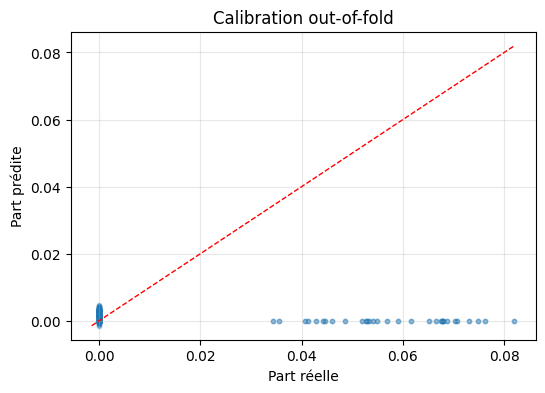

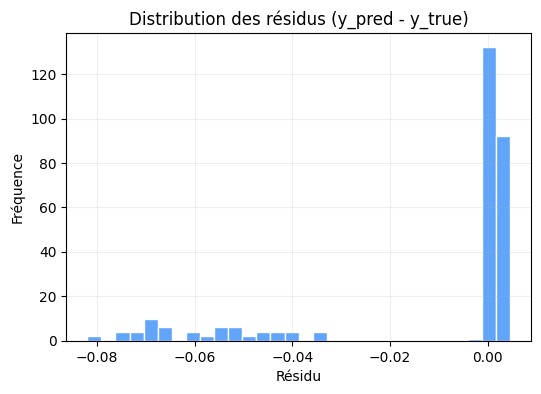

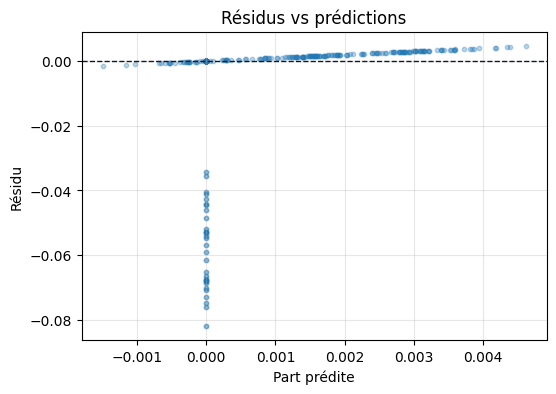

/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2170411313.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bloc_mae = diag_df.groupby("bloc").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


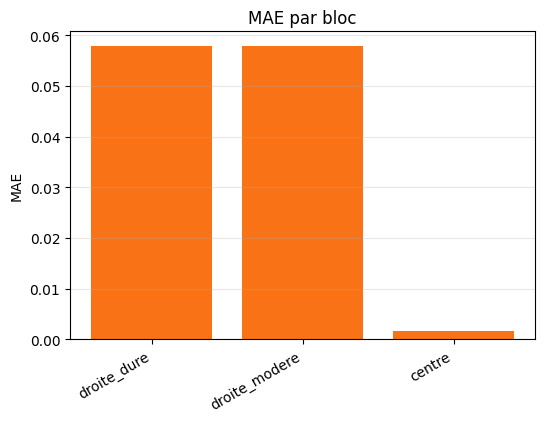

In [13]:
from sklearn.base import clone
import matplotlib.pyplot as plt

def oof_predictions(model, X, y, folds, sample_weights=None):
    preds = np.full(len(y), np.nan)
    if not folds:
        return preds
    weights = None if sample_weights is None else np.asarray(sample_weights)
    for train_idx, test_idx in folds:
        model_clone = clone(model)
        y_train = y.iloc[train_idx]
        if y_train.nunique() <= 1:
            y_train = y_train + np.random.normal(0, 1e-6, size=len(y_train))
        w_train = None if weights is None else weights[train_idx]
        fit_with_optional_weights(model_clone, X.iloc[train_idx], y_train, sample_weight=w_train)
        preds[test_idx] = model_clone.predict(X.iloc[test_idx])
    return preds

if not folds:
    print("Aucun fold disponible pour les diagnostics.")
else:
    fit_weights = sample_weights if USE_WEIGHTED_MODEL else None
    oof_pred = oof_predictions(best_model, X, y, folds, sample_weights=fit_weights)
    mask = ~np.isnan(oof_pred)
    diag_df = model_df.loc[mask, ["bloc", "code_bv"]].copy()
    diag_df["y_true"] = y[mask].values
    diag_df["y_pred"] = oof_pred[mask]
    diag_df["residual"] = diag_df["y_pred"] - diag_df["y_true"]

    # Courbe de calibration (y_true vs y_pred)
    plt.figure(figsize=(6, 4))
    plt.scatter(diag_df["y_true"], diag_df["y_pred"], alpha=0.3, s=10)
    min_val = min(diag_df["y_true"].min(), diag_df["y_pred"].min())
    max_val = max(diag_df["y_true"].max(), diag_df["y_pred"].max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)
    plt.xlabel("Part réelle")
    plt.ylabel("Part prédite")
    plt.title("Calibration out-of-fold")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Résidus
    plt.figure(figsize=(6, 4))
    plt.hist(diag_df["residual"], bins=30, color="#60a5fa", edgecolor="white")
    plt.title("Distribution des résidus (y_pred - y_true)")
    plt.xlabel("Résidu")
    plt.ylabel("Fréquence")
    plt.grid(True, alpha=0.2)
    plt.show()

    # Résidus vs prédiction
    plt.figure(figsize=(6, 4))
    plt.scatter(diag_df["y_pred"], diag_df["residual"], alpha=0.3, s=10)
    plt.axhline(0, color="#111827", linestyle="--", linewidth=1)
    plt.xlabel("Part prédite")
    plt.ylabel("Résidu")
    plt.title("Résidus vs prédictions")
    plt.grid(True, alpha=0.3)
    plt.show()

    # MAE par bloc
    bloc_mae = diag_df.groupby("bloc").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
    bloc_mae = bloc_mae.sort_values(ascending=False)
    plt.figure(figsize=(6, 4))
    plt.bar(bloc_mae.index, bloc_mae.values, color="#f97316")
    plt.title("MAE par bloc")
    plt.ylabel("MAE")
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


In [14]:
# Diagnostics par bins et queues d'erreur
if 'diag_df' not in globals() or diag_df.empty:
    print('diag_df indisponible pour les diagnostics bins/queues.')
else:
    diag_df = diag_df.copy()
    diag_df['abs_error'] = (diag_df['y_pred'] - diag_df['y_true']).abs()
    diag_df['bin_part'] = pd.cut(
        diag_df['y_true'],
        bins=[-0.001, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0],
        labels=['<=0.05', '0.05-0.10', '0.10-0.15', '0.15-0.20', '0.20-0.25', '0.25-0.30', '>0.30'],
    )
    bin_stats = (
        diag_df.groupby('bin_part')
        .agg(
            n=('abs_error', 'size'),
            mae=('abs_error', 'mean'),
            medae=('abs_error', 'median'),
            p95=('abs_error', lambda x: x.quantile(0.95)),
            p99=('abs_error', lambda x: x.quantile(0.99)),
        )
        .reset_index()
    )
    bin_stats

    # Focus zone critique 0.12-0.15
    zone_mask = (diag_df['y_true'] >= 0.12) & (diag_df['y_true'] <= 0.15)
    zone = diag_df[zone_mask]
    if zone.empty:
        print('Aucune observation dans la zone 0.12-0.15.')
    else:
        zone_stats = {
            'n': len(zone),
            'mae': zone['abs_error'].mean(),
            'medae': zone['abs_error'].median(),
            'bias': (zone['y_pred'] - zone['y_true']).mean(),
            'p95': zone['abs_error'].quantile(0.95),
            'p99': zone['abs_error'].quantile(0.99),
        }
        zone_stats

    # Quantiles globaux de résidus
    resid = diag_df['y_pred'] - diag_df['y_true']
    resid_quantiles = resid.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).to_frame('residual')
    resid_quantiles


Aucune observation dans la zone 0.12-0.15.


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/1825964428.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diag_df.groupby('bin_part')


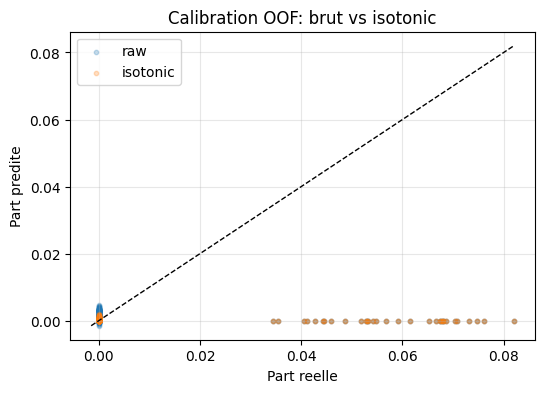

In [15]:
from sklearn.isotonic import IsotonicRegression
from sklearn.base import clone
import matplotlib.pyplot as plt

def calibrated_oof_predictions(model, X, y, folds, sample_weights=None):
    preds = np.full(len(y), np.nan)
    if not folds:
        return preds
    weights = None if sample_weights is None else np.asarray(sample_weights)
    for train_idx, test_idx in folds:
        model_clone = clone(model)
        y_train = y.iloc[train_idx]
        if y_train.nunique() <= 1:
            y_train = y_train + np.random.normal(0, 1e-6, size=len(y_train))
        w_train = None if weights is None else weights[train_idx]
        fit_with_optional_weights(model_clone, X.iloc[train_idx], y_train, sample_weight=w_train)
        pred_train = model_clone.predict(X.iloc[train_idx])
        pred_test = model_clone.predict(X.iloc[test_idx])
        iso = IsotonicRegression(out_of_bounds="clip")
        if w_train is None:
            iso.fit(pred_train, y_train)
        else:
            iso.fit(pred_train, y_train, sample_weight=w_train)
        preds[test_idx] = iso.transform(pred_test)
    return preds

if not folds:
    print("Aucun fold disponible pour la calibration.")
else:
    fit_weights = sample_weights if USE_WEIGHTED_MODEL else None
    if "oof_pred" not in globals():
        oof_pred = oof_predictions(best_model, X, y, folds, sample_weights=fit_weights)
    oof_pred_cal = calibrated_oof_predictions(best_model, X, y, folds, sample_weights=fit_weights)
    mask = ~np.isnan(oof_pred) & ~np.isnan(oof_pred_cal)
    if mask.sum() == 0:
        print("Pas de predictions OOF pour la calibration.")
    else:
        metrics_raw = regression_metrics(y[mask], oof_pred[mask])
        metrics_cal = regression_metrics(y[mask], oof_pred_cal[mask])
        winner_raw = winner_accuracy(
            y[mask].values,
            oof_pred[mask],
            blocs=model_df.loc[mask, "bloc"],
            bv_codes=model_df.loc[mask, "code_bv"],
        )
        winner_cal = winner_accuracy(
            y[mask].values,
            oof_pred_cal[mask],
            blocs=model_df.loc[mask, "bloc"],
            bv_codes=model_df.loc[mask, "code_bv"],
        )
        calib_metrics = pd.DataFrame(
            [
                {"version": "raw", **metrics_raw, "winner_acc": winner_raw},
                {"version": "isotonic", **metrics_cal, "winner_acc": winner_cal},
            ]
        )
        calib_metrics

        plt.figure(figsize=(6, 4))
        plt.scatter(y[mask], oof_pred[mask], alpha=0.25, s=10, label="raw")
        plt.scatter(y[mask], oof_pred_cal[mask], alpha=0.25, s=10, label="isotonic")
        min_val = float(np.nanmin([y[mask].min(), oof_pred[mask].min(), oof_pred_cal[mask].min()]))
        max_val = float(np.nanmax([y[mask].max(), oof_pred[mask].max(), oof_pred_cal[mask].max()]))
        plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
        plt.xlabel("Part reelle")
        plt.ylabel("Part predite")
        plt.title("Calibration OOF: brut vs isotonic")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    pred_full = best_model.predict(X)
    if np.unique(pred_full).size < 2:
        print("Calibration isotonic ignoree (predictions trop constantes).")
        iso_calibrator = None
    else:
        iso_calibrator = IsotonicRegression(out_of_bounds="clip")
        if fit_weights is None:
            iso_calibrator.fit(pred_full, y)
        else:
            iso_calibrator.fit(pred_full, y, sample_weight=fit_weights)


## Courbes d'apprentissage
Visualisation du biais/variance du meilleur modèle sur un sous-échantillon chronologique (limité pour rester rapide).


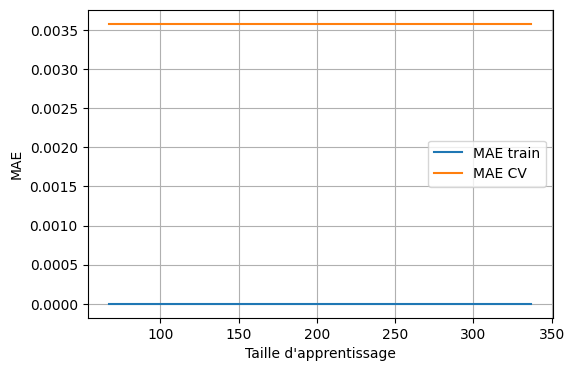

In [16]:
from sklearn.model_selection import learning_curve
from sklearn.base import clone
import matplotlib.pyplot as plt

subset = model_df.sort_values("annee").head(min(len(model_df), 5000))
if len(subset) < 5:
    print("Pas assez d'observations pour une courbe d'apprentissage fiable.")
else:
    X_lc, y_lc = subset[feature_cols], subset["part_bloc"]
    n_splits = min(3, len(subset) - 1)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_sizes, train_scores, val_scores = learning_curve(
        clone(best_model),
        X_lc,
        y_lc,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        train_sizes=np.linspace(0.2, 1.0, 5),
        n_jobs=1,
        shuffle=False,
    )
    lc_results = pd.DataFrame(
        {
            "train_size": train_sizes,
            "mae_train": -train_scores.mean(axis=1),
            "mae_cv": -val_scores.mean(axis=1),
        }
    )
    plt.figure(figsize=(6, 4))
    plt.plot(lc_results["train_size"], lc_results["mae_train"], label="MAE train")
    plt.plot(lc_results["train_size"], lc_results["mae_cv"], label="MAE CV")
    plt.xlabel("Taille d'apprentissage")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()
    lc_results


## SHAP (importance des features)
Analyse locale/globale des variables du meilleur modèle sur un échantillon limité.


/Users/steph/Code/Python/Jupyter/Elections_Sete/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


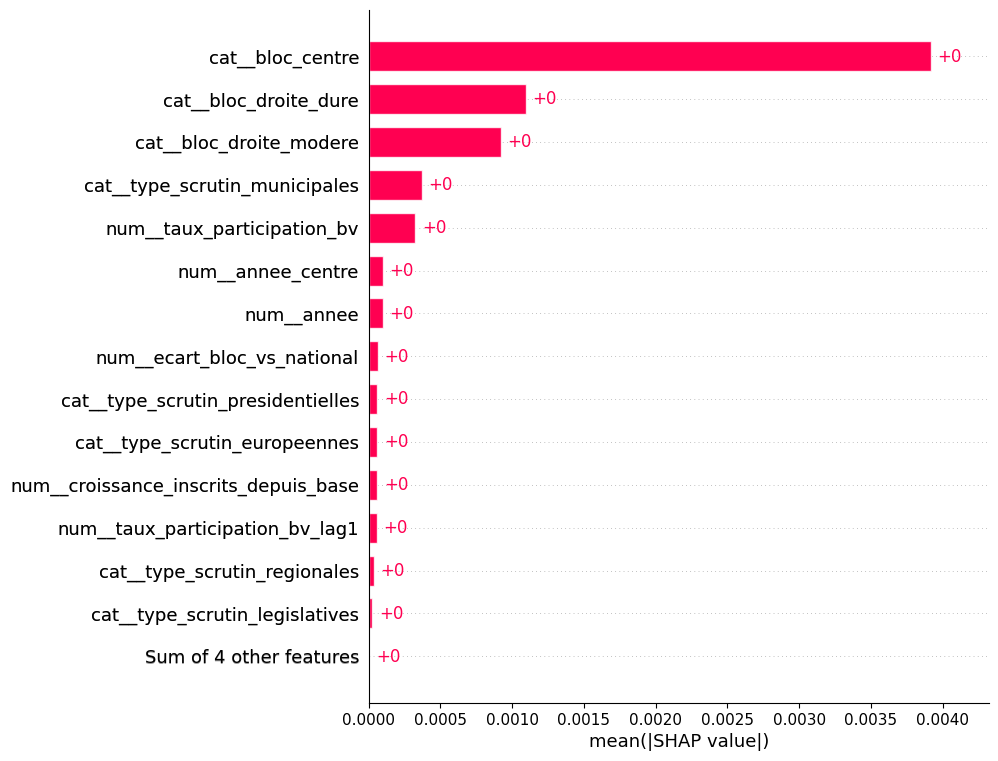

In [17]:
try:
    import shap
    shap.initjs()
    sample = model_df.sample(min(len(model_df), 1000), random_state=42)
    X_sample = sample[feature_cols]
    prep = best_model.named_steps.get("prep") if hasattr(best_model, "named_steps") else None
    estimator = best_model.named_steps.get("model") if hasattr(best_model, "named_steps") else best_model
    X_trans = prep.transform(X_sample) if prep is not None else X_sample
    if hasattr(X_trans, "toarray"):
        X_trans = X_trans.toarray()
    feature_names = None
    if prep is not None and hasattr(prep, "get_feature_names_out"):
        feature_names = prep.get_feature_names_out()
    explainer = shap.Explainer(estimator, X_trans, feature_names=feature_names)
    shap_values = explainer(X_trans[:200])
    shap.plots.bar(shap_values, max_display=15)
except Exception as exc:
    print(f"Impossible de calculer les valeurs SHAP: {exc}")


## Construction du jeu cible pour 2026
- On repart de la dernière observation de chaque bureau x bloc
- On positionne l'année et la date sur 2026, type_scrutin="municipales", tour=1
- Les variables de lag restent celles de la dernière élection connue (proxy réaliste à court terme)
- Les features sont recalculées puis passées au modèle

In [18]:
def build_target_rows(df: pd.DataFrame, target_year: int = TARGET_YEAR, target_election: str = TARGET_ELECTION):
    latest = (
        df.sort_values("date_scrutin")
        .groupby(["code_bv", "bloc"], as_index=False)
        .tail(1)
        .copy()
    )
    latest["annee"] = target_year
    latest["date_scrutin"] = pd.Timestamp(f"{target_year}-03-15")
    latest["type_scrutin"] = target_election
    latest["tour"] = 1
    latest["annee_centre"] = target_year - df["annee"].median()
    latest["part_bloc"] = np.nan
    return build_model_table(latest, drop_na_target=False)

X_target_full = build_target_rows(elections_blocs)
X_target = X_target_full[feature_cols]

pred_part = best_model.predict(X_target)
pred_part_calib = pred_part
if "iso_calibrator" in globals() and iso_calibrator is not None:
    pred_part_calib = iso_calibrator.transform(pred_part)
    pred_part_calib = np.clip(pred_part_calib, 0, 1)

pred_df = X_target_full[["code_bv", "bloc"]].copy()
pred_df["annee"] = TARGET_YEAR
pred_df["type_scrutin"] = TARGET_ELECTION
pred_df["part_bloc_predite"] = pred_part
pred_df["part_bloc_predite_calib"] = pred_part_calib
pred_df.head()


,code_bv,bloc,annee,type_scrutin,part_bloc_predite,part_bloc_predite_calib
808,343010015,droite_dure,2026,municipales,0.057774,0.069035
809,343010015,droite_modere,2026,municipales,0.057774,0.069035
647,343010012,droite_modere,2026,municipales,0.057634,0.063904
1510,343010028,droite_dure,2026,municipales,0.057712,0.063904
268,343010005,droite_dure,2026,municipales,0.057662,0.063904


## Calcul des deltas vs législatives précédentes et municipales 2020
Permet d'afficher dans Gradio l'écart à N-1 (législatives) et aux municipales 2020.

In [19]:
history = build_model_table(elections_blocs, drop_na_target=True)

last_leg = (
    history[history["type_scrutin"] == "legislatives"]
    .sort_values("date_scrutin")
    .groupby(["code_bv", "bloc"], as_index=False)
    .tail(1)
    .rename(columns={"part_bloc": "part_leg"})
)
last_mun2020 = (
    history[(history["type_scrutin"] == "municipales") & (history["annee"] == 2020)]
    .sort_values("date_scrutin")
    .groupby(["code_bv", "bloc"], as_index=False)
    .tail(1)
    .rename(columns={"part_bloc": "part_mun2020"})
)

pred_df = pred_df.merge(last_leg[["code_bv", "bloc", "part_leg"]], on=["code_bv", "bloc"], how="left")
pred_df = pred_df.merge(last_mun2020[["code_bv", "bloc", "part_mun2020"]], on=["code_bv", "bloc"], how="left")

pred_df["delta_leg"] = pred_df["part_bloc_predite"] - pred_df["part_leg"]
pred_df["delta_mun2020"] = pred_df["part_bloc_predite"] - pred_df["part_mun2020"]

if "part_bloc_predite_calib" in pred_df.columns:
    pred_df["delta_leg_calib"] = pred_df["part_bloc_predite_calib"] - pred_df["part_leg"]
    pred_df["delta_mun2020_calib"] = pred_df["part_bloc_predite_calib"] - pred_df["part_mun2020"]

pred_df.head(20)


,code_bv,bloc,annee,type_scrutin,part_bloc_predite,part_bloc_predite_calib,part_leg,part_mun2020,delta_leg,delta_mun2020,delta_leg_calib,delta_mun2020_calib
0,343010015,droite_dure,2026,municipales,0.057774,0.069035,NaN,0.068000,NaN,-0.010226,NaN,0.001035
1,343010015,droite_modere,2026,municipales,0.057774,0.069035,NaN,0.068000,NaN,-0.010226,NaN,0.001035
2,343010012,droite_modere,2026,municipales,0.057634,0.063904,NaN,0.061497,NaN,-0.003863,NaN,0.002407
3,343010028,droite_dure,2026,municipales,0.057712,0.063904,NaN,0.068653,NaN,-0.010941,NaN,-0.004749
4,343010005,droite_dure,2026,municipales,0.057662,0.063904,NaN,0.045966,NaN,0.011696,NaN,0.017938
5,343010005,droite_modere,2026,municipales,0.057662,0.063904,NaN,0.045966,NaN,0.011696,NaN,0.017938
6,343010024,droite_modere,2026,municipales,0.057768,0.068821,NaN,0.056818,NaN,0.000950,NaN,0.012003
7,343010024,droite_dure,2026,municipales,0.057768,0.068821,NaN,0.056818,NaN,0.000950,NaN,0.012003
8,343010028,droite_modere,2026,municipales,0.057712,0.063904,NaN,0.068653,NaN,-0.010941,NaN,-0.004749
9,343010012,droite_dure,2026,municipales,0.057634,0.063904,NaN,0.061497,NaN,-0.003863,NaN,0.002407


## Sauvegarde des prédictions
- Format long : `data/processed/predictions_municipales_2026.csv`
- Pivot par bloc : `data/processed/predictions_municipales_2026_blocs.csv`
- Filtre Sète (code commune 34301/301) : `data/processed/predictions_municipales_sete_2026.csv`

In [20]:
pred_out = pred_df.copy()
pred_out.to_csv(PROCESSED_DIR / "predictions_municipales_2026.csv", sep=";", index=False)

pivot = pred_out.pivot(index="code_bv", columns="bloc", values="part_bloc_predite")
pivot.to_csv(PROCESSED_DIR / "predictions_municipales_2026_blocs.csv", sep=";")

def is_sete(code_bv: str) -> bool:
    return isinstance(code_bv, str) and (code_bv.startswith("301") or code_bv.startswith("34301"))

pred_sete = pred_out[pred_out["code_bv"].apply(is_sete)]
pred_sete.to_csv(PROCESSED_DIR / "predictions_municipales_sete_2026.csv", sep=";", index=False)

pred_out.head(), pivot.head(), pred_sete.head()


(     code_bv           bloc  annee type_scrutin  part_bloc_predite  \
 0  343010015    droite_dure   2026  municipales           0.057774   
 1  343010015  droite_modere   2026  municipales           0.057774   
 2  343010012  droite_modere   2026  municipales           0.057634   
 3  343010028    droite_dure   2026  municipales           0.057712   
 4  343010005    droite_dure   2026  municipales           0.057662   
 
    part_bloc_predite_calib  part_leg  part_mun2020  delta_leg  delta_mun2020  \
 0                 0.069035       NaN      0.068000        NaN      -0.010226   
 1                 0.069035       NaN      0.068000        NaN      -0.010226   
 2                 0.063904       NaN      0.061497        NaN      -0.003863   
 3                 0.063904       NaN      0.068653        NaN      -0.010941   
 4                 0.063904       NaN      0.045966        NaN       0.011696   
 
    delta_leg_calib  delta_mun2020_calib  
 0              NaN             0.001035 

## Pistes d'amélioration
- Enrichir avec variables socio-démo INSEE (CSP, âge, revenus) au niveau IRIS/bureau
- Ajouter effets spatiaux (voisinage) et MRP/hiérarchiques pour lisser les petits bureaux
- Calibration / incertitude : bootstrap ou simulation Monte Carlo
- Optimiser les hyperparamètres (Optuna, RandomizedSearchCV) et ajouter SHAP pour l'explicabilité